# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 13            
model_seed = 3           

# --- Training configuration ---
epochs = 700            

# --- Dataset configuration ---
base_data_size = 60      
dataset_type = "data"   
dataset_quantities = [0, 600-60, 2000 - 60, 6000 - 60, 20000 - 60, 60000 - 60]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
import MNIST_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device = device
)

# MNIST specific initialization parameters
hidden_dims = [256, 256, 128]

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/700: Train Loss 2.3082 | Test Loss 2.2672 | accs Train 0.0500 Test 0.3175


Epoch 100/700: Train Loss 0.0000 | Test Loss 2.4003 | accs Train 1.0000 Test 0.6519


Epoch 200/700: Train Loss 0.0000 | Test Loss 2.3996 | accs Train 1.0000 Test 0.6509


Epoch 300/700: Train Loss 0.0000 | Test Loss 2.4015 | accs Train 1.0000 Test 0.6503


Epoch 400/700: Train Loss 0.0000 | Test Loss 2.4034 | accs Train 1.0000 Test 0.6492


Epoch 500/700: Train Loss 0.0000 | Test Loss 2.4041 | accs Train 1.0000 Test 0.6489


Epoch 600/700: Train Loss 0.0000 | Test Loss 2.4046 | accs Train 1.0000 Test 0.6498


Epoch 700/700: Train Loss 0.0000 | Test Loss 2.4038 | accs Train 1.0000 Test 0.6497
Completed training with 0 additional samples of data
Epoch 1/700: Train Loss 2.3003 | Test Loss 2.2433 | accs Train 0.0817 Test 0.3426


Epoch 100/700: Train Loss 0.0009 | Test Loss 0.7942 | accs Train 1.0000 Test 0.8630


Epoch 200/700: Train Loss 0.0003 | Test Loss 0.8410 | accs Train 1.0000 Test 0.8655


Epoch 300/700: Train Loss 0.0002 | Test Loss 0.8729 | accs Train 1.0000 Test 0.8654


Epoch 400/700: Train Loss 0.0001 | Test Loss 0.8970 | accs Train 1.0000 Test 0.8659


Epoch 500/700: Train Loss 0.0001 | Test Loss 0.9164 | accs Train 1.0000 Test 0.8659


Epoch 600/700: Train Loss 0.0001 | Test Loss 0.9325 | accs Train 1.0000 Test 0.8663


Epoch 700/700: Train Loss 0.0000 | Test Loss 0.9461 | accs Train 1.0000 Test 0.8665
Completed training with 540 additional samples of data
Epoch 1/700: Train Loss 2.3029 | Test Loss 2.2382 | accs Train 0.0880 Test 0.3906


Epoch 100/700: Train Loss 0.0067 | Test Loss 0.4547 | accs Train 1.0000 Test 0.9074


Epoch 200/700: Train Loss 0.0010 | Test Loss 0.5258 | accs Train 1.0000 Test 0.9076


Epoch 300/700: Train Loss 0.0004 | Test Loss 0.5600 | accs Train 1.0000 Test 0.9085


Epoch 400/700: Train Loss 0.0002 | Test Loss 0.5832 | accs Train 1.0000 Test 0.9091


Epoch 500/700: Train Loss 0.0002 | Test Loss 0.6008 | accs Train 1.0000 Test 0.9095


Epoch 600/700: Train Loss 0.0001 | Test Loss 0.6149 | accs Train 1.0000 Test 0.9095


Epoch 700/700: Train Loss 0.0001 | Test Loss 0.6267 | accs Train 1.0000 Test 0.9098
Completed training with 1940 additional samples of data
Epoch 1/700: Train Loss 2.3045 | Test Loss 2.2359 | accs Train 0.0933 Test 0.4111


Epoch 100/700: Train Loss 0.0343 | Test Loss 0.2392 | accs Train 0.9953 Test 0.9379


Epoch 200/700: Train Loss 0.0023 | Test Loss 0.2968 | accs Train 1.0000 Test 0.9397


Epoch 300/700: Train Loss 0.0008 | Test Loss 0.3278 | accs Train 1.0000 Test 0.9398


Epoch 400/700: Train Loss 0.0004 | Test Loss 0.3477 | accs Train 1.0000 Test 0.9396


Epoch 500/700: Train Loss 0.0003 | Test Loss 0.3626 | accs Train 1.0000 Test 0.9393


Epoch 600/700: Train Loss 0.0002 | Test Loss 0.3742 | accs Train 1.0000 Test 0.9391


Epoch 700/700: Train Loss 0.0001 | Test Loss 0.3837 | accs Train 1.0000 Test 0.9392
Completed training with 5940 additional samples of data
Epoch 1/700: Train Loss 2.3047 | Test Loss 2.2355 | accs Train 0.0938 Test 0.4230


Epoch 100/700: Train Loss 0.0925 | Test Loss 0.1491 | accs Train 0.9752 Test 0.9548


Epoch 200/700: Train Loss 0.0081 | Test Loss 0.1433 | accs Train 0.9995 Test 0.9639


Epoch 300/700: Train Loss 0.0014 | Test Loss 0.1729 | accs Train 1.0000 Test 0.9652


Epoch 400/700: Train Loss 0.0006 | Test Loss 0.1903 | accs Train 1.0000 Test 0.9653


Epoch 500/700: Train Loss 0.0003 | Test Loss 0.2023 | accs Train 1.0000 Test 0.9653


Epoch 600/700: Train Loss 0.0002 | Test Loss 0.2112 | accs Train 1.0000 Test 0.9655


Epoch 700/700: Train Loss 0.0002 | Test Loss 0.2187 | accs Train 1.0000 Test 0.9656
Completed training with 19940 additional samples of data
Epoch 1/700: Train Loss 2.3046 | Test Loss 2.2347 | accs Train 0.0961 Test 0.4335


Epoch 100/700: Train Loss 0.1197 | Test Loss 0.1301 | accs Train 0.9658 Test 0.9611


Epoch 200/700: Train Loss 0.0379 | Test Loss 0.0914 | accs Train 0.9898 Test 0.9732


Epoch 300/700: Train Loss 0.0118 | Test Loss 0.0974 | accs Train 0.9985 Test 0.9759


Epoch 400/700: Train Loss 0.0039 | Test Loss 0.1119 | accs Train 0.9998 Test 0.9767


Epoch 500/700: Train Loss 0.0016 | Test Loss 0.1244 | accs Train 1.0000 Test 0.9767


Epoch 600/700: Train Loss 0.0009 | Test Loss 0.1336 | accs Train 1.0000 Test 0.9769


Epoch 700/700: Train Loss 0.0006 | Test Loss 0.1409 | accs Train 1.0000 Test 0.9763
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 2.4038 | accs: 0.6497
 540 samples | Test Loss: 0.9461 | accs: 0.8665
1940 samples | Test Loss: 0.6267 | accs: 0.9098
5940 samples | Test Loss: 0.3837 | accs: 0.9392
19940 samples | Test Loss: 0.2187 | accs: 0.9656
59940 samples | Test Loss: 0.1409 | accs: 0.9763

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0001 | accs: 1.0000
 Model 5940 | Train Loss: 0.0001 | accs: 1.0000
 Model 19940 | Train Loss: 0.0001 | accs: 1.0000
 Model 59940 | Train Loss: 0.0003 | accs: 1.0000

Dataset type: data, additional samples: 540
 Model    0 | Train Loss: 2.3193 | accs: 0.6833
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0001 | accs: 1.0000
 Model 5940 | Train Loss: 0.0001 | accs: 1.0000
 Model 19940 | Train Loss: 0.0001 | accs: 1.0000
 Model 59940 | Trai

 Model    0 | Train Loss: 2.4945 | accs: 0.6477
 Model  540 | Train Loss: 0.9789 | accs: 0.8638
 Model 1940 | Train Loss: 0.6426 | accs: 0.9105
 Model 5940 | Train Loss: 0.3883 | accs: 0.9430
 Model 19940 | Train Loss: 0.1655 | accs: 0.9749
 Model 59940 | Train Loss: 0.0006 | accs: 1.0000


### Model + Data Specific Verification

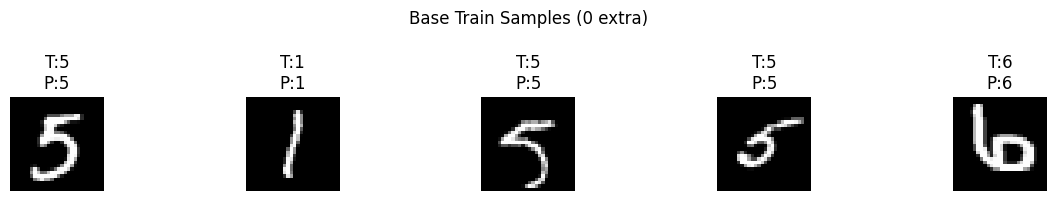

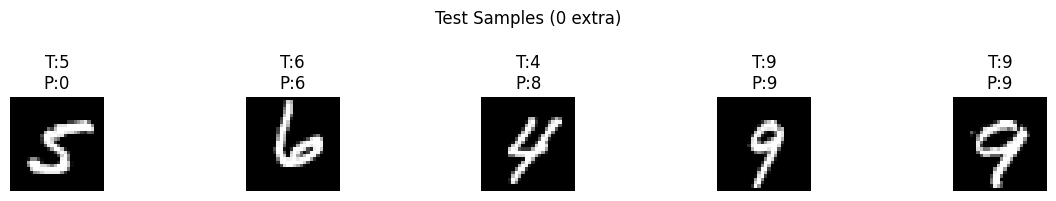

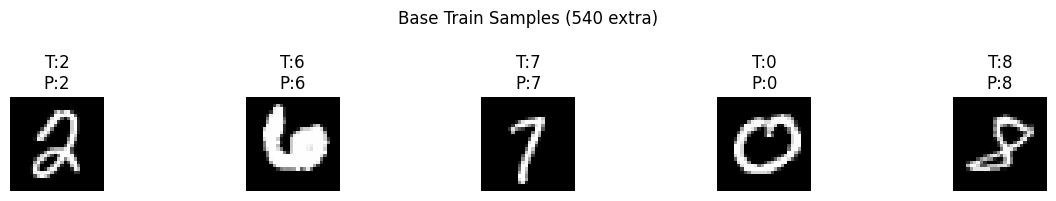

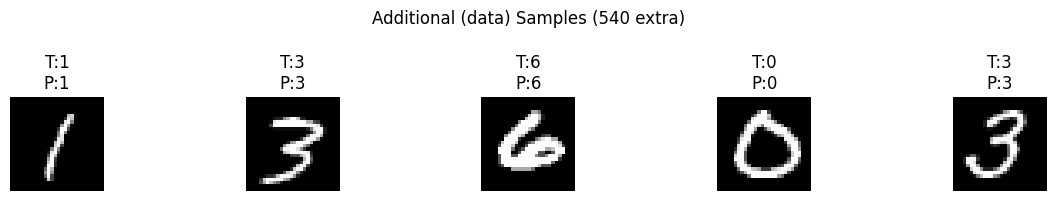

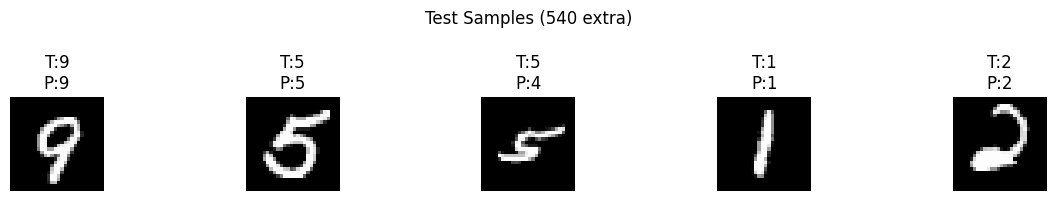

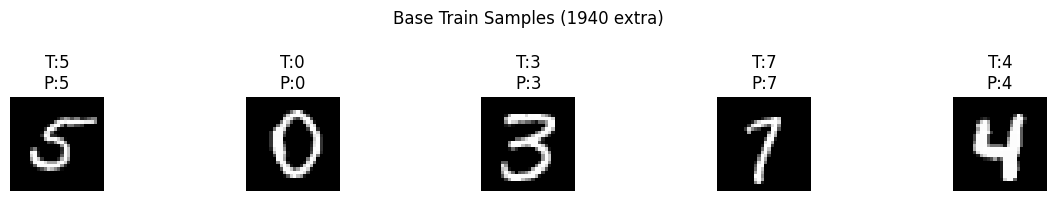

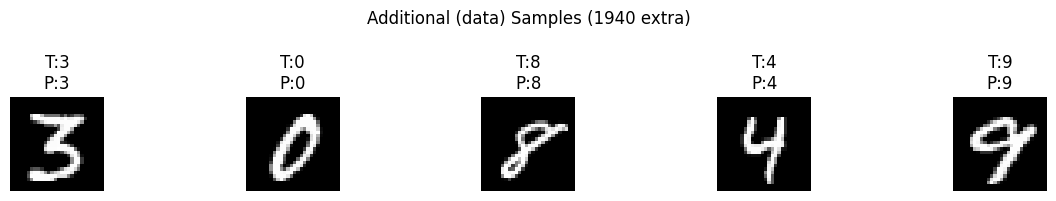

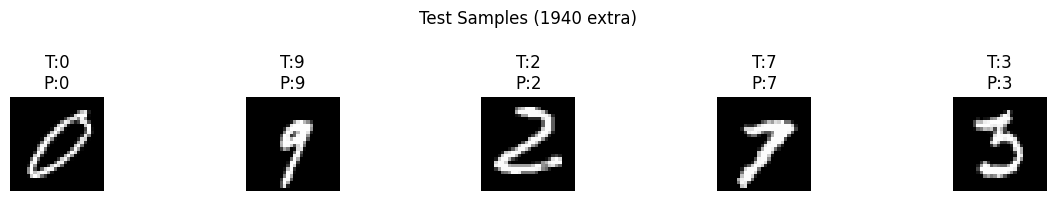

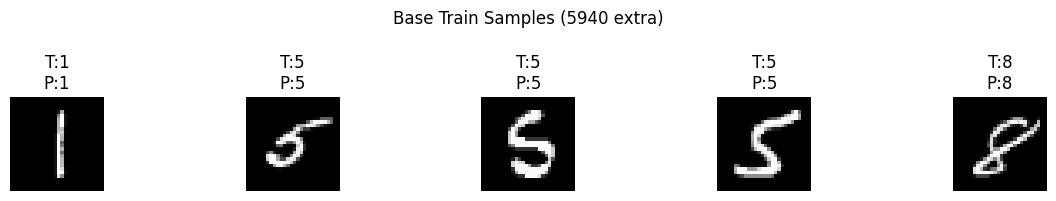

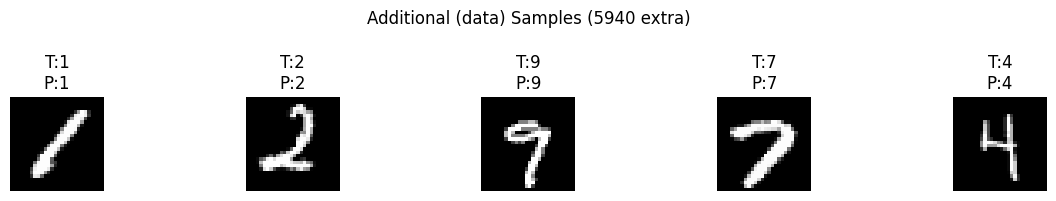

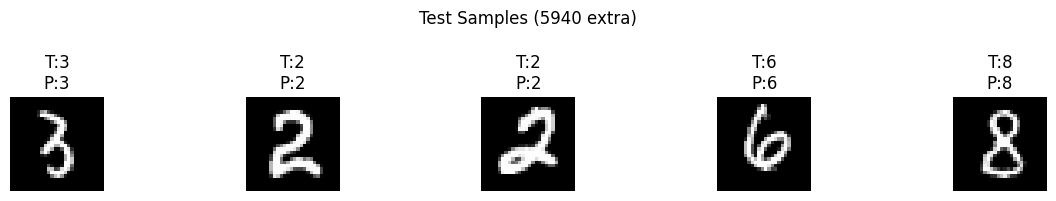

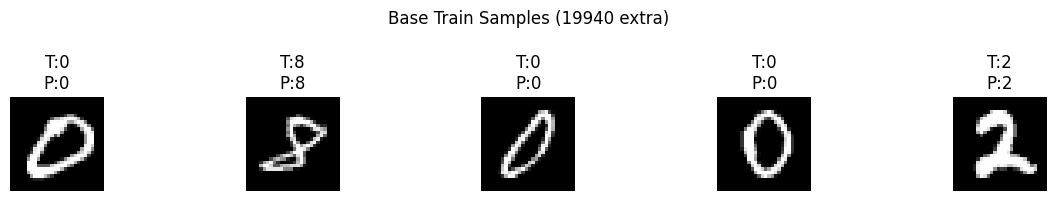

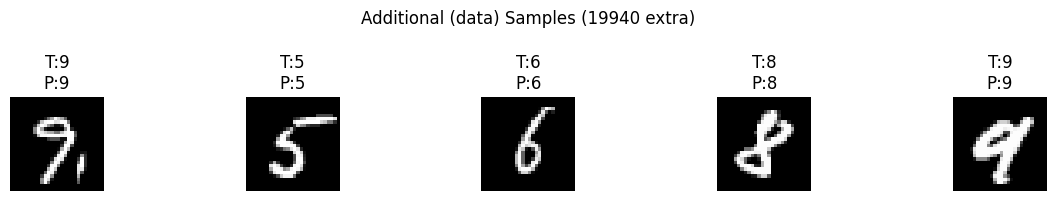

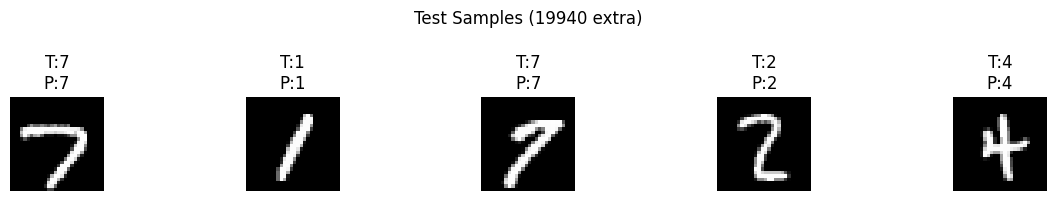

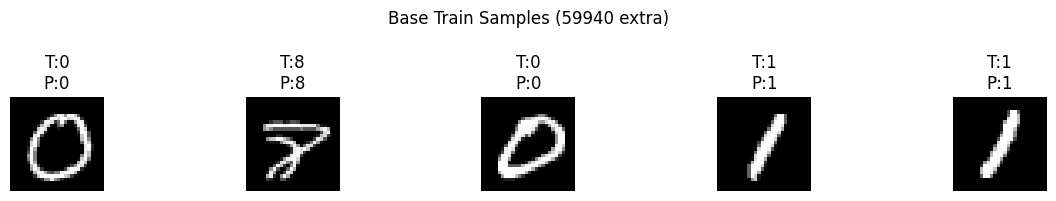

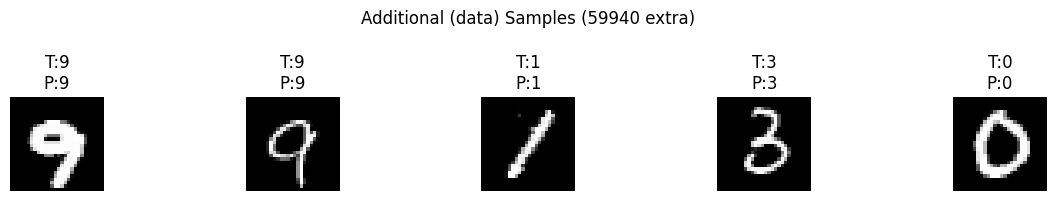

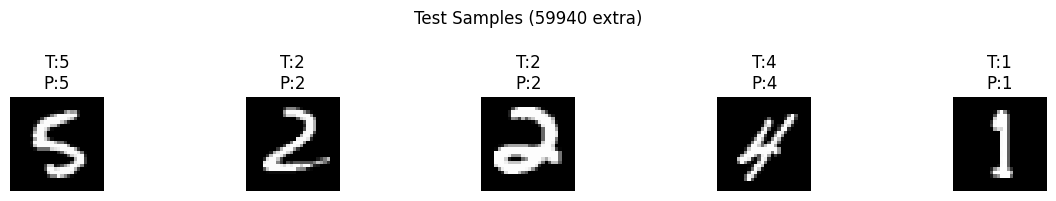

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_540.pt
Saved model: models_and_data/model_additional_540.pt
✅ Model saved to models_and_data\model_additional_1940.pt
Saved model: models_and_data/model_additional_1940.pt
✅ Model saved to models_and_data\model_additional_5940.pt
Saved model: models_and_data/model_additional_5940.pt
✅ Model saved to models_and_data\model_additional_19940.pt
Saved model: models_and_data/model_additional_19940.pt
✅ Model saved to models_and_data\model_additional_59940.pt
Saved model: models_and_data/model_additional_59940.pt
